In [1]:
from srwg_risk_toolbox import *

### parameters for risk assessment

In [10]:
foldername = 'test_run_1'
filename = 'risk_distributions.json'

if os.path.exists(Path('results',foldername)):
    print('Folder already exists.')
else:
    os.mkdir(Path('results',foldername))
    print('Results folder created.')
    
if os.path.exists(Path('results',foldername,filename)):
    raise NameError('Filename already exists. Please rename.')

Results folder created.


In [3]:
imt_list = ['SA(0.5)','SA(1.0)','SA(3.0)']
site_list = ['Wellington']
sc_list = ['IV']

In [4]:
mean_cmr = 6
std_cmr = 1.5
min_cmr = 3
max_cmr = 9

In [5]:
hazard_rp = 500
p_fatality_given_collapse = 0.1

hf_i_metric = 0 # index for the mean in the hazard curves file

In [6]:
table_file = 'data/ts_parameters_named_locations.json'
with open(table_file,'r') as f:
    sa_table = json.load(f)['data']

In [7]:
hcurves_file = 'data/hcurves_12-locations_all-NSHM-parameters.hdf5'

with h5py.File(hcurves_file,'r') as hf:
    hf_vs30_list = list(hf['metadata'].attrs['vs30s'])
    sites = pd.DataFrame(ast.literal_eval(hf['metadata'].attrs['sites']))
    hf_site_list = list(sites.index)
    imtls = ast.literal_eval(hf['metadata'].attrs['acc_imtls'])
    hf_imt_list = list(imtls.keys())
    hf_period_list = [period_from_imt(imt) for imt in hf_imt_list]
    quantiles = hf['metadata'].attrs['quantiles']
    
    hcurves = hf['hcurves']['hcurves_stats'][:]

### sample fragilities

In [8]:
n_samples = 5000
n_runs = 1

risk_results = {}
for i in range(n_runs):
    risk_results[f'v{i}'] = {}
    risk_results[f'v{i}']['metadata'] = {}
    
    risk_results[f'v{i}']['metadata']['bldg_cmrs'] = sample_cmrs(n_samples,mean_cmr,std_cmr,min_cmr,max_cmr).tolist()
    risk_results[f'v{i}']['metadata']['bldg_betas'] = sample_betas(n_samples).tolist()

### set up dictionary structure for risk analysis

In [9]:
for v_key in risk_results.keys():
    key = 'risk'
    risk_results[v_key][key] = {}
    for site in site_list:
        risk_results[v_key][key][site] = {}
        for sc in sc_list:
            risk_results[v_key][key][site][sc] = {}
            for imt in imt_list:
                risk_results[v_key][key][site][sc][imt] = {}
                for subkey in ['risk_distribution']:
                    risk_results[v_key][key][site][sc][imt][subkey] = {} 

In [13]:
for v_key in risk_results.keys():
    for i_site,site in enumerate(site_list):
        for i_sc,sc in enumerate(sc_list):
            vs30 = choose_representative_vs30(sc)
            
            pga,sas,tc = call_sa_parameters(site, hazard_rp, sc, sa_table)
            
            for i_imt,imt in enumerate(imt_list):
                period = period_from_imt(imt)
                sa_t = uhs_value(period,pga,sas,tc)

                hf_i_site = hf_site_list.index(site)
                hf_i_imt = hf_imt_list.index(imt)
                hf_i_vs30 = hf_vs30_list.index(vs30)

                hcurve = hcurves[hf_i_vs30,hf_i_site,hf_i_imt,:,hf_i_metric]
                imtl = imtls[imt]
                
                subkey = 'risk_distribution'
                risk_distribution = []
                for cmr,beta in zip(risk_results[v_key]['metadata']['bldg_cmrs'],risk_results[v_key]['metadata']['bldg_betas']):
                    median = sa_t * cmr
                    collapse_risk, disaggregation = risk_convolution(hcurve, imtl, median, beta)
                    risk_distribution.append(collapse_risk * p_fatality_given_collapse)
                risk_results[v_key][key][site][sc][imt][subkey]['array'] = risk_distribution
                risk_results[v_key][key][site][sc][imt][subkey]['mean'] = np.mean(risk_distribution)
                for q in [0.5,0.9]:
                    risk_results[v_key][key][site][sc][imt][subkey][f'{q}'] = np.quantile(risk_distribution,q)
                

In [14]:
create_dictionary_tree(risk_results,description=True)

Dictionary                                                                                   
└── v0                                                                                       
    ├── metadata                                                                             
    │   ├── bldg_cmrs (<class 'list'>)                                                       
    │   └── bldg_betas (<class 'list'>)                                                      
    └── risk                                                                                 
        └── Wellington                                                                       
            └── IV                                                                           
                ├── SA(0.5)                                                                  
                │   └── risk_distribution                                                    
                │       ├── array (<class 'list'>)                                           
                │       ├── mean (<class 'numpy.float64'>)                                   
                │       ├── 0.5 (<class 'numpy.float64'>)                                    
                │       └── 0.9 (<class 'numpy.float64'>)                                    
                ├── SA(1.0)                                                                  
                │   └── risk_distribution                                                    
                │       ├── array (<class 'list'>)                                           
                │       ├── mean (<class 'numpy.float64'>)                                   
                │       ├── 0.5 (<class 'numpy.float64'>)                                    
                │       └── 0.9 (<class 'numpy.float64'>)                                    
                └── SA(3.0)                                                                  
                    └── risk_distribution                                                    
                        ├── array (<class 'list'>)                                           
                        ├── mean (<class 'numpy.float64'>)                                   
                        ├── 0.5 (<class 'numpy.float64'>)                                    
                        └── 0.9 (<class 'numpy.float64'>)

In [15]:
with open(Path('results',foldername,filename),'w') as f:
    json.dump(risk_results,f,indent=4)

In [16]:
set_plot_formatting()
from matplotlib.lines import Line2D

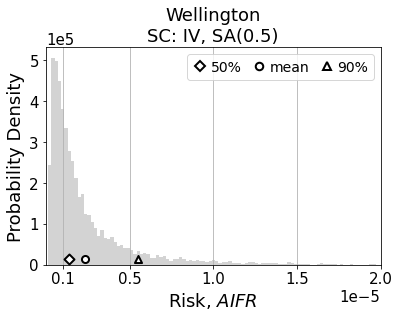

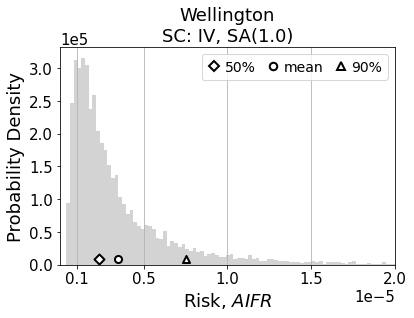

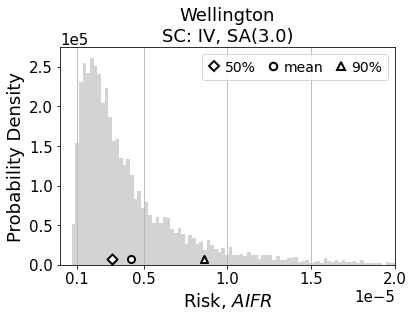

In [17]:
n_bins = 100
hist_color = 'lightgray'

max_x = 2e-5
x_ticks = np.array([0.1,0.5,1,1.5,2])*1e-5

marker_size = 50
marker_yscale = 0.025

ylabel = 'Probability Density'
xlabel = 'Risk, $\it{AIFR}$'

key = 'risk'
subkey = 'risk_distribution'
for v_key in risk_results.keys():
    for i_site,site in enumerate(site_list):
        for i_sc,sc in enumerate(sc_list):
            for i_imt,imt in enumerate(imt_list):
                
                fig,ax = plt.subplots(1,1)
                
                dist = risk_results[v_key][key][site][sc][imt][subkey]['array']
                _ = ax.hist(dist,bins=n_bins,density=True,color=hist_color)
                max_y = ax.get_ylim()[1]
                
                mean = risk_results[v_key][key][site][sc][imt][subkey]['mean']
                p50 = risk_results[v_key][key][site][sc][imt][subkey]['0.5']
                p90 = risk_results[v_key][key][site][sc][imt][subkey]['0.9']
                
                legend_handles = []
                for i_stat,stat in enumerate([p50,mean,p90]):
                    label = ['50%','mean','90%'][i_stat]
                    marker = ['D','o','^',][i_stat]
                    _ = ax.scatter(stat,marker_yscale*max_y,s=marker_size,marker=marker,color='w',edgecolor='k',lw=2,zorder=10-i_stat)
                    legend_handles.append(Line2D([0],[0],color='w',marker=marker,markersize=7.5,markerfacecolor='w',markeredgecolor='k',markeredgewidth=2,label=label))
                _ = ax.legend(handles=legend_handles,loc='upper right',handlelength=1,handletextpad=0.25,fontsize=14,ncol=3,columnspacing=0.75)

                _ = ax.set_xlim([0,max_x])
                _ = ax.set_ylim([0,max_y])
                _ = ax.ticklabel_format(style='sci',scilimits=(0,0))
                _ = ax.set_ylabel(ylabel)
                _ = ax.set_xlabel(xlabel)
                _ = ax.set_xticks(x_ticks)
                _ = ax.grid(axis='x',ls='-')
                _ = ax.set_title(f'{site}\nSC: {sc}, {imt}')